CUDA 버전 확인하기

- !nvidia-smi
- !nvcc --version

둘의 차이점은
nvidia-smi는 해당 장치에서 설치 가능한 가장 높은 버전을 보여주고,
nvcc --version은 현재 설치된 cuda 버전을 보여줌

출처 : https://stackoverflow.com/questions/9727688/how-to-get-the-cuda-version

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# PyTorch 2.x 버전 설치
try:
    # 기본적으로 https://pytorch.kr/get-started/locally/ 에서
    # cuda 버전과 패키지매니저에 맞는 설치 명령어를 확인 가능
    # %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    print(torch.__version__)
except:
    pass

2.0.1+cu118


In [3]:
# pytorch에서 사용할 함수들 호출하기
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

----------------------------------------------------------

# CNN 으로 이미지 분석하기

## ****1. Mnist 데이터로 Convolution2D로 구현하기****

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 106462710.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43124134.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25541005.84it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17938351.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_dataset[10004]

(<PIL.Image.Image image mode=L size=28x28 at 0x798837732DD0>, 9)

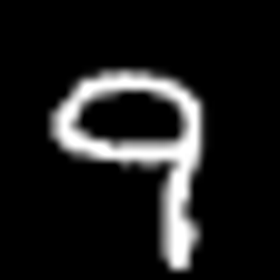

In [6]:
train_dataset[10004][0].resize((280, 280))  # size 28x28 -> 280x280으로 조정

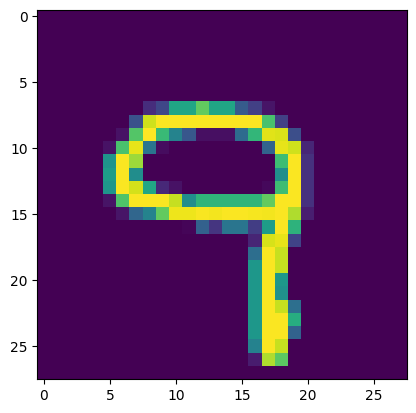

In [7]:
from matplotlib import pyplot as plt

plt.figure()
plt.imshow(train_dataset[10004][0])
plt.show()

## 2. 이미지를 학습시키기 위한 처리

1. ToTensor: 이미지를 학습이 가능하도록 숫자화한다. (Image, np,ndarray[W, H, C] -> tensor[C, W, H])
https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html

2. Normalize: CNN 성능을 높이기 위한 처리 (채널별로 각각 다른 평균, 분산을 적용 가능하다.)
https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html

In [8]:
# 이미지를 학습이 가능하도록 숫자화
to_tensor = transforms.ToTensor()

In [9]:
image_tensor = to_tensor(train_dataset[10004][0])

In [10]:
image_tensor.shape

torch.Size([1, 28, 28])

In [11]:
# 단일 채널이므로 하나의 채널에만 평균 0.1307, 분산 0.3081로 조정한다.
normalizer = transforms.Normalize((0.1307,), (0.3081,))

In [12]:
normalizer(image_tensor)

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

알아서 적용할수는 없을까?

-> 당연히 있다.

transforms.Compose([  
&nbsp;&nbsp;&nbsp;&nbsp;적용할 변형들  
])

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

In [14]:
# train_dataset에 transform 적용
train_dataset.transform = transform

## DataLoader 생성

- PyTorch는 모델을 학습시킬 때 batch_size만큼 데이터를 뽑아서 Dataset의 처리를 진행한 뒤 모델에 주입한다.
- 지금은 Dataset을 커스텀하여 사용하지 않고 있지만, 이러한 처리를 DataLoader가 해준다는 것은 분명 큰 이점이다.
- n_workers 옵션은 이를 병렬적으로 수행 가능하게 한다.

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

## 모델 구축

In [16]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # self.name
        self.conv = nn.Sequential(
            # image size = 28x28x1
            nn.Conv2d(1, 64, 3, 1),     # (input channel, output channel, kernel size, stride(, padding))
            # image size = 26x26x64
            nn.ReLU(True),
            nn.MaxPool2d(2),        # kernel size = 2
            # image size = 13x13x64
            nn.Conv2d(64, 128, 3, 1),
            # image size = 11x11x128
            nn.ReLU(True),
            nn.MaxPool2d(2),
            # image size = 5x5x128
            nn.Conv2d(128, 256, 3, 1),
            # image size = 3x3x256
            nn.ReLU(True),)

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 32),    # 3x3x256 = 2304
            nn.ReLU(True),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        output = self.classification(x)
        return output

In [17]:
cnn = MyCNN()

In [18]:
cnn

MyCNN(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=32, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [19]:
# 모델 학습을 위한 옵티마이저와 스케줄러 정의
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cnn.to(device)

# loss를 multiclass 분류에 적합한 loss인 cross entropy loss를 사용
criterion = nn.CrossEntropyLoss().cuda()

optimizer = optim.Adadelta(cnn.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [20]:
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [21]:
# 모델 학습 (tensorflow는 fit 하나로 아래의 과정을 처리한다.)
epochs = 10
dry_run = False # 1 배치만 훈련

for epoch in range(1, epochs+1):
    # 학습
    cnn.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

    # 테스트
    cnn.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = cnn(data)
            test_loss += criterion(output, target).detach().sum()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338754
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.308076
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.316218
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.022588
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.005952
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.149470
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.066473
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.336593
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.039851
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.001658
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.047873
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.012198
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.098834
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.008053
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.004315
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.003060
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.011587
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.002607
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.001219

Test set: Average loss: 0.0011, Accuracy: 9896/10000 (99%)

KeyboardInterrupt: ignored

### 모델의 구조를 이해해보자.  
output shape : 피처맵의 크기 * 채널  
param : weight의 개수

In [22]:
%pip install torchinfo
from torchinfo import summary
summary(cnn)

# ouptut image의 크기는?
# 가중치의 개수는?

Layer (type:depth-idx)                   Param #
MyCNN                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       73,856
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       295,168
│    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      73,760
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      330
Total params: 443,754
Trainable params: 443,754
Non-trainable params: 0

In [ ]:
# input channel = 1, output channel = 64, kernel size = 3
(3*3+1)*64 = 640
# input channel = 64, output channel = 128, kernel size = 3
(3*3*64+1)*128 = 73856
# input channel = 128, output channel = 256, kernel size = 3
(3*3*128+1)*256 = 295168
# input channel = 256
(3*3*256) = 2304


In [ ]:
(3*3*1+1)*64
(3*3*64+1)*128
(3*3*128+1)*256
3*3*256
(2304+1)*32
(32+1)*10

## ****2.cifar10 데이터로 Convolution2D로 구현해보기****

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 77733717.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [25]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [26]:
# 역정규화
denormalize = transforms.Compose([
     transforms.Normalize((0., 0., 0.), (1/0.5, 1/0.5, 1/0.5)),
     transforms.Normalize((-0.5, -0.5, -0.5), (1., 1., 1.)),
     ])

In [27]:
i = 5
denormalize(train_dataset[i][0])

tensor([[[0.6235, 0.5882, 0.6000,  ..., 0.3569, 0.2902, 0.2980],
         [0.5569, 0.5725, 0.6078,  ..., 0.4980, 0.4784, 0.3373],
         [0.4275, 0.3882, 0.4118,  ..., 0.5373, 0.6392, 0.3647],
         ...,
         [0.9569, 0.9412, 0.9451,  ..., 0.6118, 0.7020, 0.7843],
         [0.9647, 0.9529, 0.9529,  ..., 0.6353, 0.6980, 0.7529],
         [0.9647, 0.9529, 0.9569,  ..., 0.6510, 0.6784, 0.7137]],

        [[0.4000, 0.3569, 0.3725,  ..., 0.2784, 0.2471, 0.2275],
         [0.2941, 0.2824, 0.2980,  ..., 0.4118, 0.4353, 0.2706],
         [0.2627, 0.2275, 0.2314,  ..., 0.4392, 0.5176, 0.2824],
         ...,
         [0.5059, 0.4824, 0.4784,  ..., 0.1647, 0.2314, 0.2863],
         [0.5216, 0.5020, 0.4980,  ..., 0.1725, 0.2196, 0.2549],
         [0.5451, 0.5216, 0.5176,  ..., 0.1843, 0.2000, 0.2235]],

        [[0.3961, 0.3725, 0.3804,  ..., 0.2196, 0.2157, 0.2157],
         [0.2667, 0.2588, 0.2549,  ..., 0.2784, 0.3647, 0.2392],
         [0.2941, 0.2353, 0.2039,  ..., 0.3137, 0.4118, 0.

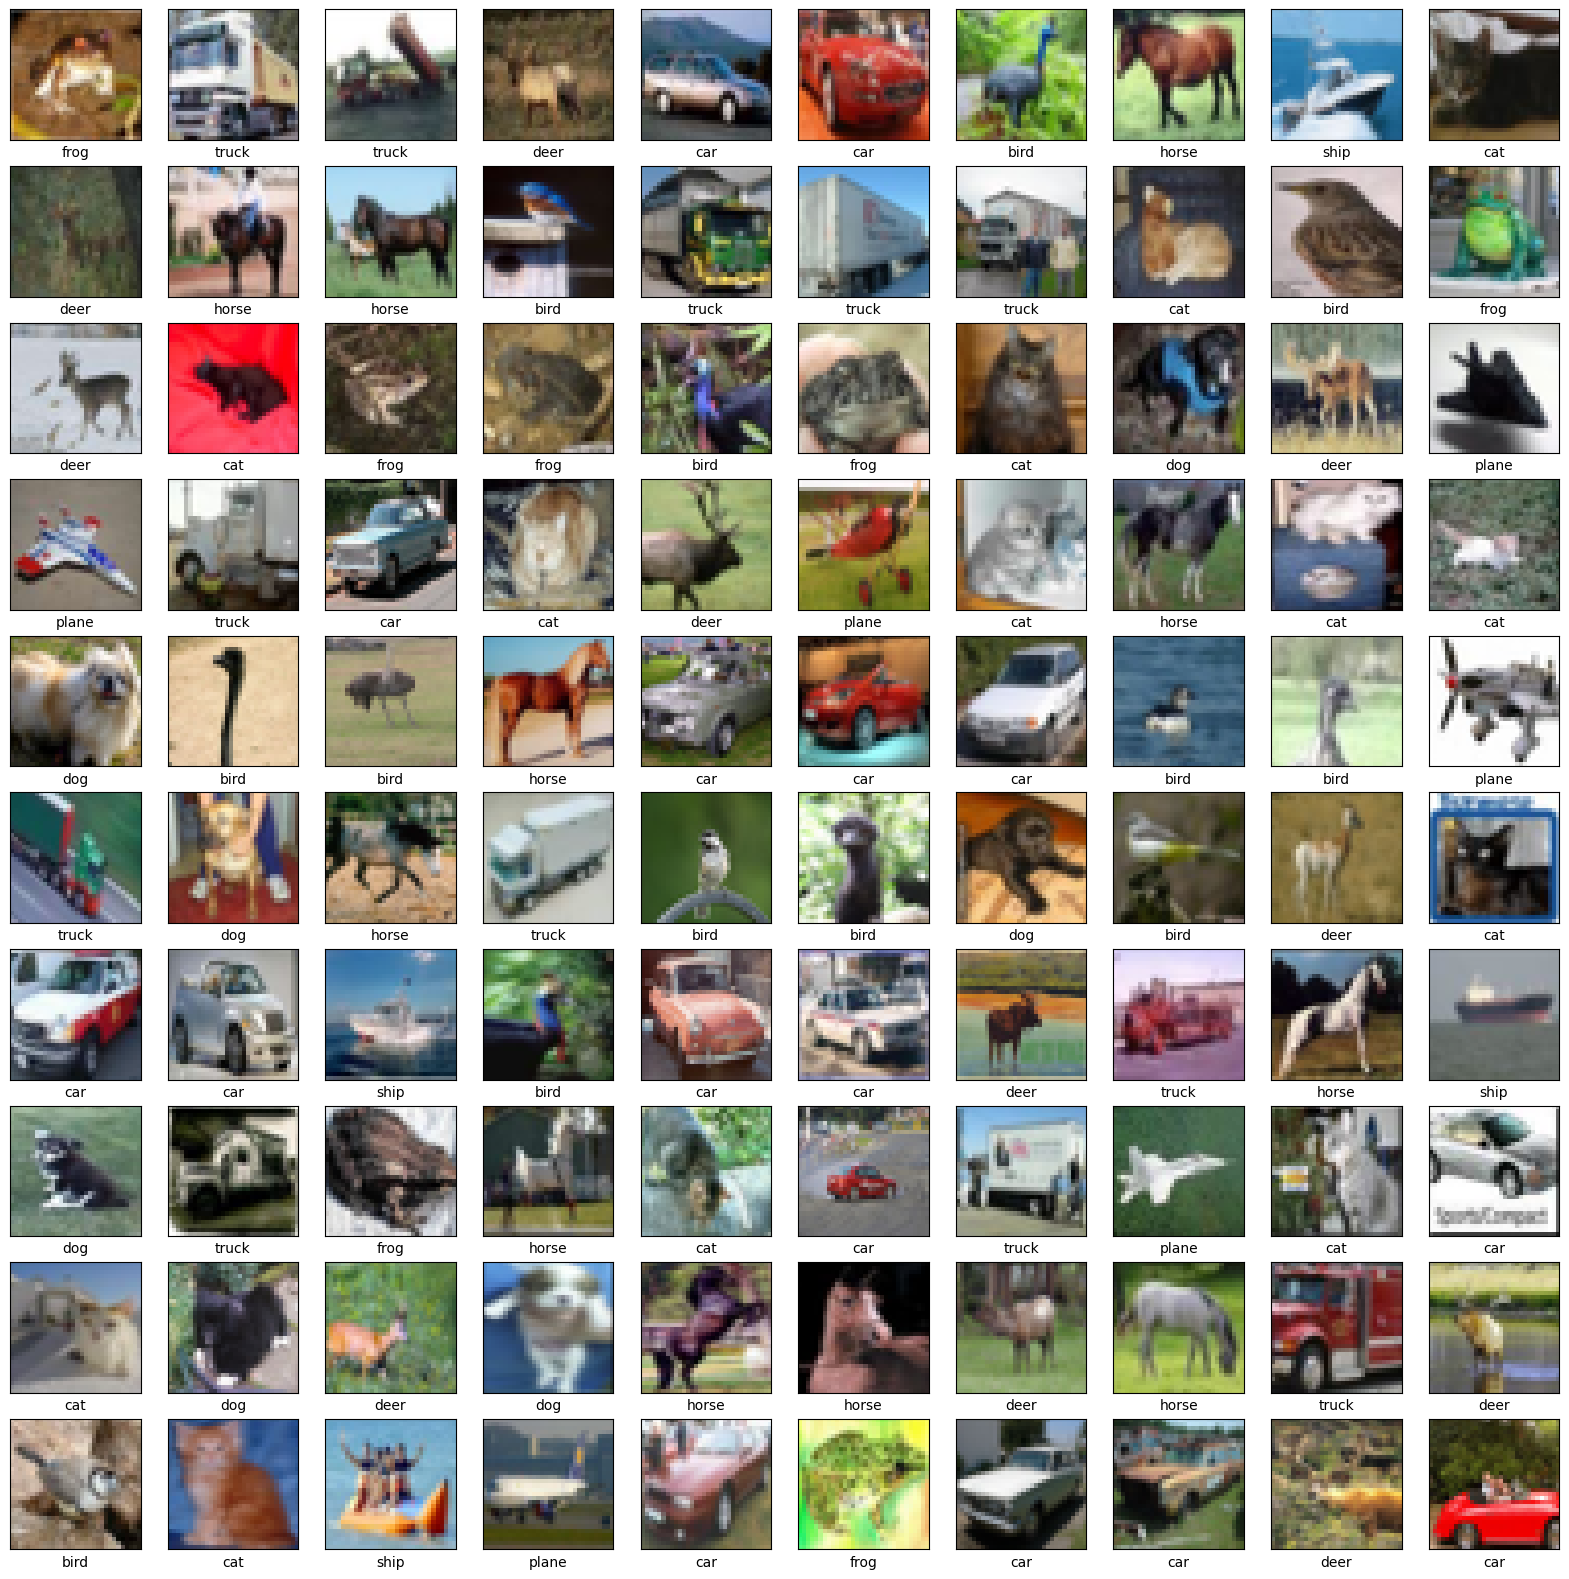

In [28]:
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(denormalize(train_dataset[i][0]).permute(1, 2, 0)) # C, W, H -> W, H, C
    plt.xlabel(classes[train_dataset[i][1]])
plt.show()

In [29]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # self.name
        # 각 이미지의 크기는 어떻게 변할까?
        self.convolution = nn.Sequential(
            # 3x32x32
            nn.Conv2d(3, 64, 3, 1),     # weight 수 = (3*3*3+1)*64
            # 30x30x64
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 15x15x64
            nn.Conv2d(64, 128, 3, 1),   # weight 수 = (3*3*64+1)*128
            # 13x13x128
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 6x6x128
            nn.Conv2d(128, 256, 3, 1),  # weight 수 = (3*3*128+1)*256
            # 4x4x256
            nn.ReLU(),)

        self.fully_connected = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.convolution(x)
        x = torch.flatten(x, 1)
        output = self.fully_connected(x)
        return output

In [30]:
model = MyCNN()

In [31]:
model

MyCNN(
  (convolution): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [32]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MyCNN                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       73,856
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       295,168
│    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-9                       524,416
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      1,290
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0

In [33]:
# 모델 학습을 위한 옵티마이저와 스케줄러 정의
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.CrossEntropyLoss().cuda()

optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [34]:
# 모델 학습 (tensorflow는 fit 하나로 아래의 과정을 처리한다.)
epochs = 10
dry_run = False # 1 배치만 훈련

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            if dry_run:
                break

    # 테스트
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).detach().sum()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.310311
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.121632
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.779439
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.425022
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.723903
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.523230
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.049024
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.543135
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.578782
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.675020
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.517639
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.149915
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.253638
Train Epoch: 1 [41600/50000 (83%)]	Loss: 0.634436
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.208152
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.193543

Test set: Average loss: 0.0366, Accuracy: 5938/10000 (59%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.981664
Train Epoch: 2 [3200/50000 (6%)]	Loss: 0.895555
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.935977
Train 

### CNN 응용모델들

https://pytorch.org/vision/stable/models.html

In [1]:
import torchvision.models as tc_models
dir(tc_models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [2]:
resnet = tc_models.resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 47.1MB/s]


In [3]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
resnet = tc_models.resnet50(weights=None)

In [5]:
import torch

# Option 1: passing weights param as string
model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")

# # Option 2: passing weights param as enum
# weights = torch.hub.load("pytorch/vision", "get_weight", weights="ResNet50_Weights.IMAGENET1K_V2")
# model = torch.hub.load("pytorch/vision", "resnet50", weights=weights)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip


In [8]:
from torchinfo import summary
summary(model)

ModuleNotFoundError: ignored